In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [21]:
df = pd.read_csv("../DATA/aus_livestock.csv")
df = df[df.unique_id.str.contains("Victoria")]
df["ds"] = pd.to_datetime(df.ds)

,unique_id,ds,y
3036,"Victoria_Bulls, bullocks and steers",1976-07-01,109200.0
3037,"Victoria_Bulls, bullocks and steers",1976-08-01,94700.0
3038,"Victoria_Bulls, bullocks and steers",1976-09-01,95500.0
3039,"Victoria_Bulls, bullocks and steers",1976-10-01,94800.0
3040,"Victoria_Bulls, bullocks and steers",1976-11-01,94100.0
...,...,...,...
28801,Victoria_Sheep,2018-08-01,469900.0
28802,Victoria_Sheep,2018-09-01,381900.0
28803,Victoria_Sheep,2018-10-01,481700.0
28804,Victoria_Sheep,2018-11-01,433100.0


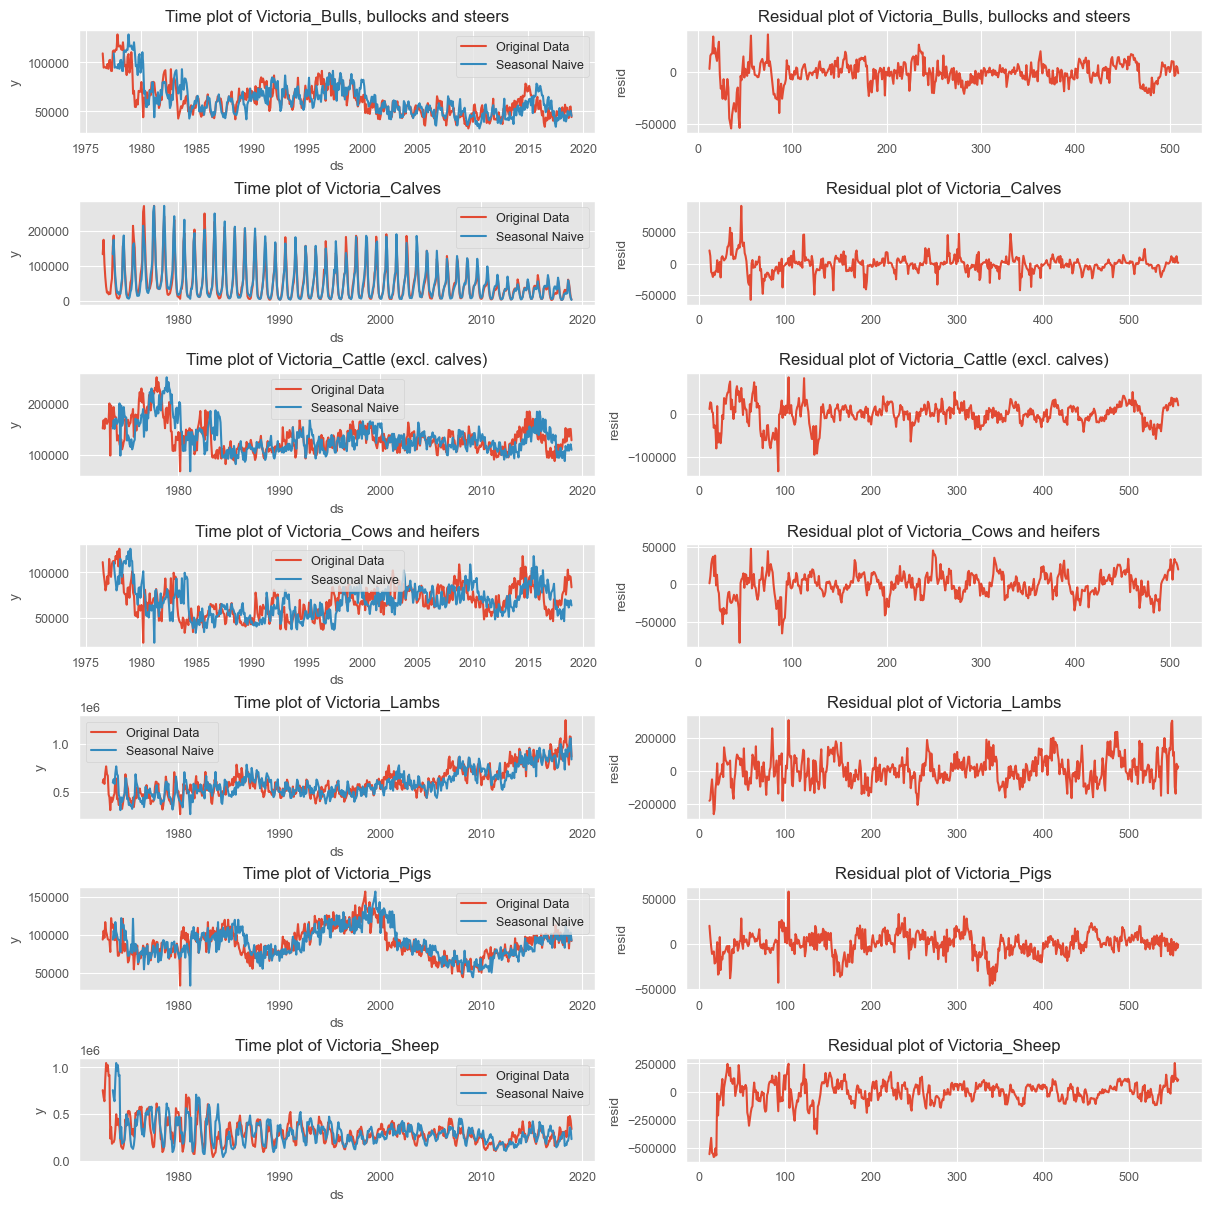

In [38]:
fig, axes = plt.subplots(7, 2, figsize=(12,12))
for axs, series_id in zip(axes, df.unique_id.unique()):
    data = df[df.unique_id == series_id]
    method = SeasonalNaive(season_length=12)
    sf = StatsForecast(models=[method], freq="M")
    sf.fit(df=data)
    sf.forecast(h=10, fitted=True, df=data)
    insample_preds = sf.forecast_fitted_values()

    sns.lineplot(x=data.ds, y=data.y, label="Original Data", ax=axs[0])
    sns.lineplot(
        x=insample_preds.ds,
        y=insample_preds.SeasonalNaive,
        label="Seasonal Naive",
        ax=axs[0],
    )
    axs[0].set_title(f'Time plot of {series_id}')
    axs[1].set_title(f'Residual plot of {series_id}')

    # Look at the residuals
    insample_preds["resid"] = insample_preds["y"] - insample_preds["SeasonalNaive"]
    sns.lineplot(insample_preds["resid"], ax=axs[1])